<a href="https://colab.research.google.com/github/casjunior93/Desafio-DIO-Sistema-de-Recomendacao-por-Imagens-Digitais/blob/main/Sistema_de_Recomenda%C3%A7%C3%A3o_por_Imagens_Digitais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Criando um Sistema de Recomendação por Imagens Digitais

## Bibliotecas

In [1]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

## Habiltando Google Drive

In [2]:
%%time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
CPU times: user 802 ms, sys: 165 ms, total: 967 ms
Wall time: 25.8 s


## Importando biblioteca do Kaggle e minhas credenciais.

In [3]:
%%time
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77733 sha256=df2a1f8550da74b762925c930953d7bea43119bddf72813ec5ef4accaad4a561
  Stored in directory: /root/.cache/pip/wheels/9c/45/15/6d6d116cd2539fb8f450d64b0aee4a480e5366bb11b42ac763
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.13
    Uninstalling kaggle-1.5.13:
      Successfully uninstalled kaggle-1.5.13
CPU times: user 77.1 ms, sys: 35.8 ms, total: 113 ms
Wall time: 8.41 s


## Obtendo os dados

In [4]:
%%time
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/images/58150.jpg  
  inflating: myntradataset/images/58151.jpg  
  inflating: myntradata

In [5]:
%%time
os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [02:31<00:00, 292.78it/s]

Moved 44441 images.
CPU times: user 2min 16s, sys: 3.35 s, total: 2min 19s
Wall time: 2min 31s


## Transferência de aprendizado

Baixando o modelo de imagem pré-treinado e adicionando duas camadas adicionais: a primeira camada é uma camada de vetor de recursos e a segunda camada é a camada de classificação. Vamos treinar apenas essas 2 camadas em nossos dados e, após o treinamento, selecionaremos a camada de vetor de recursos como saída de nosso codificador ajustado. Depois de ajustar o modelo, salvaremos o extrator de recursos para uso posterior.

In [6]:
%%time
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
Hub version: 0.13.0
GPU is available
CPU times: user 2.36 s, sys: 404 ms, total: 2.77 s
Wall time: 3.16 s


In [7]:
%%time
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32 
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)
CPU times: user 511 µs, sys: 15 µs, total: 526 µs
Wall time: 414 µs


In [8]:
%%time
data_dir = '/content/Fashion_data/categories'

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


In [9]:
%%time
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.
CPU times: user 738 ms, sys: 192 ms, total: 931 ms
Wall time: 796 ms


Construindo o modelo com Keras

In [10]:
%%time
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 212,748,999
Trainable params: 1,574,919
Non-trainable params: 211,174,080
_________________________________________

Compilando o modelo

In [11]:
%%time
# Define optimiser and loss
lr = 0.003 * BATCH_SIZE / 512 
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

CPU times: user 30.3 ms, sys: 1.07 ms, total: 31.4 ms
Wall time: 66.1 ms


Treinando o modelo

In [12]:
%%time
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
1111/1111 [==============================] - 1317s 1s/step - loss: 0.2533 - accuracy: 0.9681 - val_loss: 0.1394 - val_accuracy: 0.9904
Epoch 2/5
1111/1111 [==============================] - 1298s 1s/step - loss: 0.1946 - accuracy: 0.9762 - val_loss: 0.1393 - val_accuracy: 0.9903
Epoch 3/5
1111/1111 [==============================] - 1299s 1s/step - loss: 0.1976 - accuracy: 0.9768 - val_loss: 0.1392 - val_accuracy: 0.9904
Epoch 4/5
1111/1111 [==============================] - 1299s 1s/step - loss: 0.2003 - accuracy: 0.9758 - val_loss: 0.1391 - val_accuracy: 0.9904
Epoch 5/5
1111/1111 [==============================] - 1299s 1s/step - loss: 0.1947 - accuracy: 0.9768 - val_loss: 0.1390 - val_accuracy: 0.9904
CPU times: user 17min 31s, sys: 5min 27s, total: 22min 58s
Wall time: 1h 51min 20s


Perda e acurácia durante o treinamento do modelo.

CPU times: user 48.8 ms, sys: 0 ns, total: 48.8 ms
Wall time: 72.1 ms


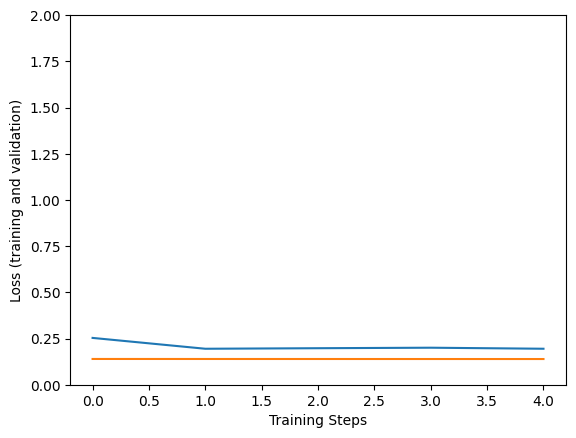

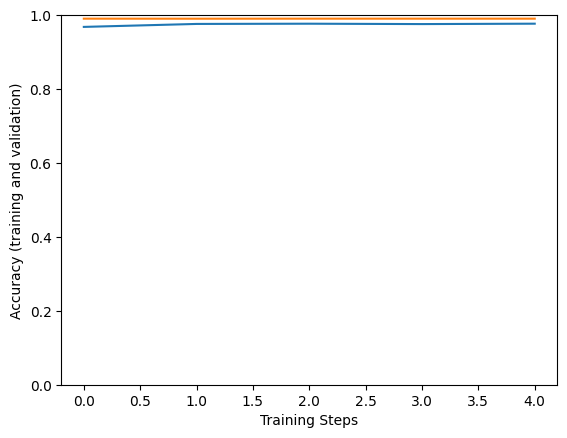

In [13]:
%%time
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Salvando o modelo:

In [14]:
%%time
if not os.path.exists('/content/drive/MyDrive/ImgSim/'):
    os.mkdir('/content/drive/MyDrive/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/drive/MyDrive/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/content/drive/MyDrive/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

CPU times: user 30.2 s, sys: 2.65 s, total: 32.8 s
Wall time: 40.7 s
